In [1]:
#|default_exp augment

In [ ]:
#|export
import torch,random
import fastcore.all as fc

from torch import nn
from torch.nn import init

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [2]:
#|export
import pickle,gzip,math,os,time,shutil
import matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,optim
from torch.utils.data import DataLoader,default_collate
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from fastcore.test import test_close
from torch import distributions

In [3]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [4]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
ds_builder.info.features
xl,yl = ds_builder.info.features
num_classes = ds_builder.info.features['label'].num_classes

In [5]:
#xl,yl = 'image','label'
#name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [7]:
set_seed(42)
lr,epochs = 6e-2,5

## Going wider

We took the convnet and replaced it with a Resnet, so it's effectively twice as deep,
as each conv block has 2 convolutions. 
But Resnets train better than convNets, so we could go deeper and wider.
Previously we were going from 8 up to 256 filters. 
Could we get up to 512?
We can make the first `ResBlock` layer have a kernel size `ks=5` (instead of 3), and `stride=1`.
Each grid is 5x5, 25 inputs, so it is fair to have 16 outputs.
Then as we keep doubling (`nfs`) we end up at 512 filters. 

In [8]:
def get_model(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], num_classes, bias=False), nn.BatchNorm1d(num_classes)]
    return nn.Sequential(*layers)

In [9]:
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

After training 5 epochs with `lr=1e-2` accuracy is .925. 

accuracy,loss,epoch,train
0.823,0.707,0,train
0.846,0.536,0,eval


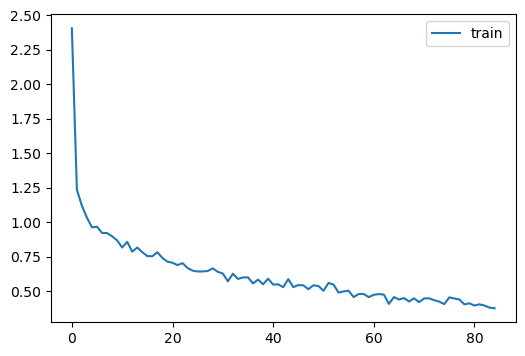

KeyboardInterrupt: 

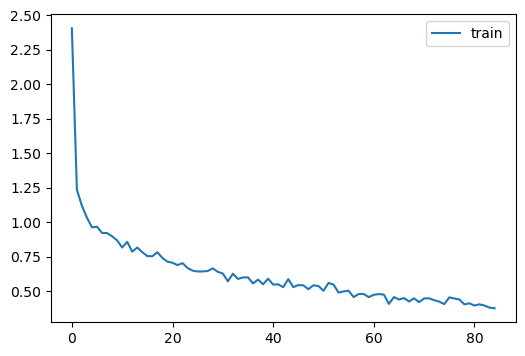

In [10]:
learn.fit(epochs)

### Pooling

Lets make the Resnet more flexible.
The current Resnet requires the number of stride-2 layers to be big enough so 
that the last `ResBlock` ends with a 1x1 output, so we can `Flatten` it and do the `Linear`.
That's not flexible, e.g., if we've got images of a different size. 
28x28 is a pretty small image size.
Lets create `get_model2` which has one less layer, only goes up to 256 despite starting at 16. 
Because it's got one less layer, the last `ResBlock` will be 2x2 not 1x1. 
We can the take the mean over the 2x2, returning a tensor of batch size (1024) by Channel's output (256), i.e., 1024x256.
which we can then pass into the `Linear` layer.
This "mean" is called (Keras naming) a *Global Average Pooling* `GlobalAvgPool` layer.
In Pytorch it is called an *Adaptive Average Pooling* layer, and can have an output other than 1x1.
(Nobody uses it that way so they're basically the same.)
`GlobalAvgPool` is more convenient (than Pytorch's version) because we don't have to `Flatten` it.
After our last `ResBlock` which returns a 2x2 output we have a `GlobalAvgPool()` layer,
and then we can do the `Linear` and `BatchNorm1d` as usual.

In [ ]:
class GlobalAvgPool(nn.Module):
    def forward(self, x): return x.mean((-2,-1))

In [ ]:
def get_model2(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [ResBlock(nfs[-1], nfs[-1]*2, act=act, norm=norm), GlobalAvgPool()]
    layers += [nn.Linear(nfs[-1]*2, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

#### Estimate of Computation to improve Summary

Lets improve the `Learner.summary()` with a `@patch` to include an estimate of computation, "MFLOPS".
This calculation is not exact, (it's not flops), rather an indicative approximation 
count of the number of multiplications.
The `_flops` function gets a weight matrix `x`, the height `h` and the width `w` of the grid.
If the number of dimensions `x.dim() < 3`, then we're doing e.g., a linear layer, 
and we return the number of elements `x.numel()` as estimate of the number of "flops".
If we're doing a convolution, `x.dim==4`, we return `x.numel()*h*w`.
That's how we calculate and return a proxy for flops... 

In [ ]:
#|export
def _flops(x, h, w):
    if x.dim()<3: return x.numel()
    if x.dim()==4: return x.numel()*h*w
    raise Exception()

@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|MFLOPS|\n|--|--|--|--|--|\n'
    totp,totf = 0,0
    def _f(hook, mod, inp, outp):
        nonlocal res,totp,totf
        nparms = sum(o.numel() for o in mod.parameters())
        totp += nparms
        *_,h,w = outp.shape
        flops = sum(_flops(o, h, w) for o in mod.parameters())/1e6
        totf += flops
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|{flops:.1f}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, cbs=SingleBatchCB())
    print(f"Tot params: {totp}; MFLOPS: {totf:.1f}")
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

#### Model2

When we run `model2` the number of parameters went from 1.2M up to 4.9M,
because of the last `ResBlock` that gets up to 512 filters (adds 3.6M parameters). 
The last `ResBlock` has a default `stride=1` layer, so it stayed at 2x2, 
to make it as similar as possible with the last ones.
It's got the same 512 final number of filters, so most of the parameters are in that last block.
NB: The last one has 73% of the total parameters, but only 45% of the MFLOPS. 
This is because the first (input) layer has to be done 28x28 times, 
while the last ResBlock only has to be done 2x2 times.

In [ ]:
TrainLearner(get_model2(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

In [ ]:
set_seed(42)
model = get_model2(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

Training `model2` got a similar result .927

#### Model3 Reduce number of Parameters

What would reduce the number of parameters (memory) and megaflots (compute)?
In `model3` lets remove the last ResBlock (that takes it up to 512), 
and the number of parameters goes down to (25%)  (4.9M to 1.2M).
Not as big an impact on the megaflops (55%). 

In [ ]:
def get_model3(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [ ]:
TrainLearner(get_model3(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

On the first `ResBlock`, we have 5.3 MFLOPS because the 2nd conv is 16x16 by 5x5.<br>
This is showing how to investigate what's going on in a model.
TODO: try these investigations.

In [ ]:
[o.shape for o in get_model3()[0].parameters()]

We train it, and even though it's only a quarter of the size we get about the same accuracy .926.

In [ ]:
set_seed(42)
model = get_model3(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

#### Model4 Make it faster by replacing 1 ResBlock by one convolution

Can we make it faster?
The first (input) `ResBlock` has the bulk of the compute.
There the 2nd conv is 16x16 channels out by 5x5 kernels, and it's doing it across the whole 28x28 grid.
We can replace the first `ResBlock` with just one convolution, and we've got rid of the 16x16 by 5x5. 

In [ ]:
def get_model4(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [conv(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [ ]:
[o.shape for o in get_model4()[0].parameters()]

We just got the 16x1 by 5x5 and the Total MFLOPS is down to 73% from 18.3 to 13.3.

In [ ]:
TrainLearner(get_model4(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

The number of parameters hasn't changed much (it was only 6884).
<mark>When a "model has less parameters", it doesn't mean it's faster.</mark>
The relationship between parameters and speed doesn't take account the time for things moving through memory.

In [ ]:
set_seed(42)
model = get_model4(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

`model4` has less compute (Megaflops) and about the same accuracy.
We've built something that is fast small and accurate: 
has less parameters and less Megaflops and has the same accuracy.
An important thing to keep in mind.
This model is better than the resnet18d from `timm`. 

#### Train longer

What if we train for longer? 
If we train for 20 epochs the training accuracy gets up to .999, but the validation accuracy is worse, .924.
After 20 epochs it's seen the same image so many times it's memorizing them, and things go downhill.
We need to regularize.
We have claimed that we can regularize using weight decay, but here weight Decay doesn't regularize at all.

After 20 epochs without augmentation:

```
{'accuracy': '0.999', 'loss': '0.012', 'epoch': 19, 'train': True}
{'accuracy': '0.924', 'loss': '0.284', 'epoch': 19, 'train': False}
```

With batchnorm, weight decay doesn't really regularize.

<span style='color:Green'> (*for years people didn't notice this, until a paper pointed this out*) </span>
A batchNorm layer has a single set of coefficients which multiplies an entire layer.
That set of coefficients could just be e.g., the number 100 in every place.
That's going to multiply the entire previous (weights or convolution kernel) matrix by 100.
As far as weight Decay is concerned that's not much of an impact,
because the batchNorm layer has very few weights.
So it doesn't really have a huge impact on weight decay, but it increases the effective scale of the weight Matrix.
<br>
batchNorm lets the ANN "cheat" by increasing the coefficients the parameters 
nearly as much as it wants indirectly just by changing the batch normally as weights.
<mark> Weight decay is not going to save us with batchNorm layers.</mark> 
Important to recognize, JH doesn't see the point of it.
Studies of BatchNorm show that it has some 2nd order effects on the LR.
We should use a scheduler for changing the LR rather than 2nd order effects caused by weight decay.

We're going to modify every image a little bit by a random change,
so that the ANN doesn't see the same image each time.
As this is a separate area, we don't implement these from scratch...
(Can look them up in FastAI vision augment, e.g., flip, cropping, padding, etc.
FastAI probably has the best implementation but `torchvision`'s are fine, so we'll use them.

In [ ]:
from torchvision import transforms

We've created before a `BatchTransformCB` callback for normalization.
We could create a transform batch function `tfm_batch` which transforms the inputs `tfm_x` 
and transforms the outputs `tfm_y` using two different functions.
That would be an augmentation callback.
We want to transform our X's using `tfms`, a `Sequential` module,
which first does a random crop `RandomCrop` and then a random horizontal flip `RandomHorizontalFlip`.
It is weird to randomly crop a 28x28 image to get a 28x28 image,  
but we can add padding to it and so it's going to randomly add padding on one or both sides
to do this kind of random crop.

The `BatchTransformCB` has `on_train` and `on_val` arguments (see `BatchTransformCB??`) so that it only does it 
if we say we want to do it on training and it's training,
or we want to do it on validation and it's not training.

Data augmentation shouldn't be done on validation so we set `on_valid=False`.

In [ ]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

tfms = nn.Sequential(transforms.RandomCrop(28, padding=4),
                     transforms.RandomHorizontalFlip())

augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[SingleBatchCB(), augcb])

In [ ]:
learn.fit(1)

Data augmentation shouldn't be done on validation so we set `on_val=False`.
First we use `SingleBbatchCB()` and `fit(1)` just doing training.
The we grab the batch out of the learner, to see exactly what the model sees.
This is not relying on any approximations.
When we fit it puts it in the batch that looks at into learn.batch.
So if we fit for a single batch we can then grab that batch back, and we can show images.
We can see a little crop it's added.
Notice that every single image in this batch (lets grab the first 16) has exactly the same augmentation,
as we're applying a batch transform.
This is good because it is running on the GPU, and it's really hard to get enough CPU to feed a fast GPU.
Particularly on some platforms (kaggle, collab) that are really underpowered for CPU.
This way all of Transformations augmentation is happening on the GPU.
On the downside, there's less variety as every minibatch has the same augmentation.
The downside may not matter because it's going to see lots of minibatches, and
each minibatch is going to have a different augmentation.
If we run this multiple times it's got a different augmentation in each minibatch.

In [ ]:
xb,yb = learn.batch
show_images(xb[:16], imsize=1.5)

In [ ]:
#| export
@fc.patch
@fc.delegates(show_images)
def show_image_batch(self:Learner, max_n=9, cbs=None, **kwargs):
    self.fit(1, cbs=[SingleBatchCB()]+fc.L(cbs))
    show_images(self.batch[0][:max_n], **kwargs)

In [ ]:
learn.show_image_batch(max_n=16, imsize=(1.5))

We are going to use one padding, a small amount of data augmentation, 20 epochs using onecycleLR.
Takes a while to train and gets .940.

In [ ]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

Asked Twitter if anybody beat this in 20 epochs any model/Library and nobody's got close.
In papers with code there are better models but use 250 or more epochs.
TODO: find a way to beat this in 20 epochs.

In [ ]:
set_seed(42)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

A custom collation function could let you do per-item transformations.

Since this takes a while to train, we should `torch.save` it so we can load that back later.

In [ ]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)
torch.save(learn.model, mdl_path/'data_aug.pkl')

## Test Time Augmentation

TTA does the batch transform callback on validation too.
Here we do a simple TTA, adding a batch transform callback that runs on validate.
It's not random, just does a horizontal flip.
A new callback `CapturePreds()`, after each batch appends to a list `all_preds` the predictions, 
and appends to `all_targs` the targets. <br>
<mark> NB: The code below was changed after the class, added `after_fit`, `@fc.patch`, etc </mark>

In [ ]:
#| export
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_inps,self.all_preds,self.all_targs = [],[],[]
    def after_batch(self, learn):
        self.all_inps. append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))
    def after_fit(self, learn): 
        self.all_preds,self.all_targs,self.all_inps = map(torch.cat, [self.all_preds,self.all_targs,self.all_inps])

In [ ]:
#| export
@fc.patch
def capture_preds(self: Learner, cbs=None, inps=False):
    cp = CapturePreds()
    self.fit(1, train=False, cbs=[cp]+fc.L(cbs))
    res = cp.all_preds,cp.all_targs
    if inps: res = res+(cp.all_inps,)
    return res

We can call `learn.fit(1, train=False, .....)` and it will show us the accuracy.
This is the same number that we saw before.

In [ ]:
ap1, at = learn.capture_preds()

We can call the same thing but this time with a different callback,
the horizontal flip callback, `TF.hflip`. <br>
It does the same thing as before, but every time it's going to do a horizontal flip.
Accuracy is slightly higher (??).

In [ ]:
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])

And we've now got two sets of predictions: with and without the flipped version.

In [ ]:
ap1.shape,ap2.shape,at.shape

We could stack those together and take the average of the flipped and unflipped predictions.
That gives us a better result .94, which is better because we are looking at
the image from multiple (here 2) different directions, (flipped and unflipped), 
it gives it more opportunities to understand what this is a picture of.
This is a bit like bagging, getting multiple predictions and bringing them together.

In [ ]:
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)

.942 is the best 20 epoch result and notice we didn't have to do any additional training.
It still counts as a 20 Epoch result.
We can do test time augmentation with a much wider range of different augmentations that you trained with.
And then you can use them at test time too, crops, rotations, warps, etc.

In [ ]:
round((ap==at).float().mean().item(), 3)

We're going to delete a little bit of each picture and replace it with some random gaussian noise.
In this case we've just got one patch but eventually we're going to do more than one patch.
We have to implement everything from scratch and this one's a bit less trivial than the previous transforms.

Let's grab the first 16 images of a batch out of the training set.

In [ ]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]

Let's grab the mean and standard deviation.

In [ ]:
xm,xs = xbt.mean(),xbt.std()

In [ ]:
xbt.min(), xbt.max()

Deleting a patch would change the statistics.
But if we replace the image with exactly the same mean and standard deviation pixels that the picture has,
then it won't change the statistics.
Let's say we want to delete `pct=0.2` of the height and width.

In [ ]:
pct = 0.2

Let's find out how big that size is.
0.2 of the shape is the height and of the width that's the size of the X and Y.
Forn the starting point we're just going to randomly grab some starting point.
The starting points for X and Y, `stx=14` and `sty=0`, and the patch is a 5x5 spot.

In [ ]:
szx = int(pct*xbt.shape[-2])
szy = int(pct*xbt.shape[-1])
stx = int(random.random()*(1-pct)*xbt.shape[-2])
sty = int(random.random()*(1-pct)*xbt.shape[-1])
stx,sty,szx,szy

We do a gaussian or normal initialization of our minibatch.
Everything in the batch, every channel for this x slice this y slice,
and we're going to initialize it with this mean and standard deviation normal random noise.

<mark> Don't start by writing a function, start by writing single lines of code that can run independently,
make sure that they work, e.g., look at the pictures.</mark>

In [ ]:
init.normal_(xbt[:,:,stx:stx+szx,sty:sty+szy], mean=xm, std=xs);

One thing that looks wrong is that some of the backgrounds looks black and others gray.
At first this was confusing, what's the change, as the original images didn't look like that.

In [ ]:
show_images(xbt, imsize=1.5)

The problem is that the minimum and the maximum have changed, from -0.8,2  to now -3,3. 
The noise we added has the same mean and standard deviation but it doesn't have the same range 
because the pixels were not normally distributed originally.
So normally distributed noise is wrong.

In [ ]:
xbt.min(), xbt.max()

`_rand_erase1` fixes this. It does all the same as before,
but it `x.clamps_` the random pixels to be between `mn` and `mx`.
It makes sure that it doesn't change the range, important as the range impacts the activations a lot.

In [ ]:
#|export
def _rand_erase1(x, pct, xm, xs, mn, mx):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx = int(random.random()*(1-pct)*x.shape[-2])
    sty = int(random.random()*(1-pct)*x.shape[-1])
    init.normal_(x[:,:,stx:stx+szx,sty:sty+szy], mean=xm, std=xs)
#    import pdb; pdb.set_trace()
    x.clamp_(float(mn), float(mx))

Now all of the backgrounds have that nice black.

In [ ]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
_rand_erase1(xbt, 0.2, xbt.mean(), xbt.std(), xbt.min(), xbt.max())
show_images(xbt, imsize=1.5)

And it's still giving us random pixels.
Because of the clamping the mean and standard deviation aren't 0-1, but they're very very close.
And `min` and `max` haven't changed because we clamped them.

In [ ]:
xbt.mean(),xbt.std(),xbt.min(), xbt.max()

We create a  `rand_erase` that will randomly choose up to (e.g., 4 blocks).

In [ ]:
#|export
def rand_erase(x, pct=0.2, max_num = 4):
    xm,xs,mn,mx = x.mean(),x.std(),x.min(),x.max()
    num = random.randint(0, max_num)
    #num = random.randint(1, max_num)
    for i in range(num): _rand_erase1(x, pct, xm, xs, mn, mx)
    # print(num)
    return x

Below is what this data augmentation looks like.

In [ ]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
rand_erase(xbt, 0.2, 4)
show_images(xbt, imsize=1.5)

The class `RandErase` will do this data augmentation.
We pass in what percentage to do in each block, what is the maximum number of blocks to have it store that away.
In `forward()` we call `rand_erase()` function passing in the input `x`, and the arguments.

In [ ]:
#|export
class RandErase(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct,self.max_num = pct,max_num
    def forward(self, x): return rand_erase(x, self.pct, self.max_num)

Now we can use `RandomCrop` `RandomHorizontalFlip` and `RandErase`.

In [ ]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandErase())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [ ]:
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])
learn.fit(1)
xb,yb = learn.batch
show_images(xb[:16], imsize=1.5)

Now we're going to go all the way up to 50 epochs, and we get .946.

In [ ]:
epochs = 50
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

In [ ]:
learn.fit(epochs)

Noticed that we don't end up with zero-one, and clamping feels a bit weird.
How do we replace the pixels with something that is guaranteed to be the correct distribution?
A: we can copy another part of the picture to have the correct distribution of pixels.
This is *Random copying*, lets implement it manually.

In [ ]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]

Let's get our `xb` minibatch and the sizes, etc. 

In [ ]:
szx = int(pct*xbt.shape[-2])
szy = int(pct*xbt.shape[-1])
stx1 = int(random.random()*(1-pct)*xbt.shape[-2])
sty1 = int(random.random()*(1-pct)*xbt.shape[-1])
stx2 = int(random.random()*(1-pct)*xbt.shape[-2])
sty2 = int(random.random()*(1-pct)*xbt.shape[-1])
stx1,sty1,stx2,sty2,szx,szy

Now we are copying, not erasing.
Now instead of random noise we say replace this (left) slice of the batch with this (right) slice of the batch.

In [ ]:
xbt[:,:,stx1:stx1+szx,sty1:sty1+szy] = xbt[:,:,stx2:stx2+szx,sty2:sty2+szy]

We end up with copied little bits across some.
We can't really see it all, some of them are black and it's replaced black..
I guess it's knocked off the end of this shoe, added a little bit extra here, etc.

In [ ]:
show_images(xbt, imsize=1.5)

We'll randomly `_rand_copy1` get a different X Y to copy from.
Lets turn it into a function... once it was tested above) (in the repl??)
to make sure the function works.

In [ ]:
#|export
def _rand_copy1(x, pct):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx1 = int(random.random()*(1-pct)*x.shape[-2])
    sty1 = int(random.random()*(1-pct)*x.shape[-1])
    stx2 = int(random.random()*(1-pct)*x.shape[-2])
    sty2 = int(random.random()*(1-pct)*x.shape[-1])
    x[:,:,stx1:stx1+szx,sty1:sty1+szy] = x[:,:,stx2:stx2+szx,sty2:sty2+szy]

And it's copying it, notice that frequently the copy is from something that's largely black.

In [ ]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
_rand_copy1(xbt, 0.2)
show_images(xbt, imsize=1.5)

Again we do it multiple times, and get a couple of random copies.

In [ ]:
#|export
def rand_copy(x, pct=0.2, max_num = 4):
    num = random.randint(0, max_num)
    for i in range(num): _rand_copy1(x, pct)
#     print(num)
    return x

In [ ]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
rand_copy(xbt, 0.2, 4)
show_images(xbt, imsize=1.5)

Turn that into a class

In [ ]:
#|export
class RandCopy(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct,self.max_num = pct,max_num
    def forward(self, x): return rand_copy(x, self.pct, self.max_num)

create our transforms.

In [ ]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandCopy())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

We look at a batch to make sure it looks sensible.

In [ ]:
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])
learn.fit(1)
xb,yb = learn.batch
show_images(xb[:16], imsize=1.5)

When we fit for 25 epochs it gets to .94.

In [ ]:
set_seed(1)
epochs = 25
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

After above training for 25 epochs, we can train a whole new model for a different 25 epochs, and put in a different Learner `learn2`. 

In [ ]:
model2 = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn2 = TrainLearner(model2, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn2.fit(epochs)

`learn2` is .941 and `learn` was 94. 

In [ ]:
mdl_path = Path('models')
torch.save(learn.model,  mdl_path/'randcopy1.pkl')
torch.save(learn2.model, mdl_path/'randcopy2.pkl')

We can ensemble them, grab the predictions of `learn` and `learn2`, 
stack them up and take their mean. 
The ensemble returns .944, better than either of the models.
We still didn't beat our best but it's a particularly useful trick.

In [ ]:
cp1 = CapturePreds()
learn.fit(1, train=False, cbs=cp1)

In [ ]:
cp2 = CapturePreds()
learn2.fit(1, train=False, cbs=cp2)

In [ ]:
cp2.all_preds.shape, cp1.all_targs.shape

<mark> Possible error in doing torch.cat unecessarily? </mark>

In [ ]:
#ap1 = torch.cat(cp1.all_preds)
#ap2 = torch.cat(cp2.all_preds)
#at = torch.cat(cp1.all_targs)
ap1 = cp1.all_preds
ap2 = cp2.all_preds
at = cp1.all_targs
ap1.shape,ap2.shape, at.shape

In [ ]:
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)

In [ ]:
round((ap==at).float().mean().item(), 3)

Was trying to improve by using ensembling with same number of epochs,
instead of training for longer.
We couldn't, maybe because the random copy is not as good, 
or maybe we are using too much augmentation.
"cut mix" is similar to this,  cut mix copies it from different images rather
than from the same image.

## Dropout

In [ ]:
from torch import distributions
p = 0.1
dist = distributions.binomial.Binomial(probs=1-p)
dist.sample((10,))
     

In [ ]:
class Dropout(nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p

    def forward(self, x):
        if not self.training: return x
        dist = distributions.binomial.Binomial(tensor(1.0).to(x.device), probs=1-self.p)
        return x * dist.sample(x.size()) * 1/(1-self.p)

In [ ]:
def get_dropmodel(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d, drop=0.0):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm), nn.Dropout2d(drop)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), Dropout(drop), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [ ]:
set_seed(42)
epochs=5
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_dropmodel(act_gr, norm=nn.BatchNorm2d, drop=0.1).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
     

In [ ]:
learn.fit(epochs)

In [ ]:
class TTD_CB(Callback):
    def before_epoch(self, learn):
        learn.model.apply(lambda m: m.train() if isinstance(m, (nn.Dropout,nn.Dropout2d)) else None)

## Augment2

JH added this new section which replaces the transform `transformi` with something
that goes from -1 to 1.
Then creates the data loaders `dls` and then trains a model 
that can classify fashion, and saved the trained model as `data_aug2.pkl`.
It is the same as before, but it is a fashion classifier where the inputs are expected to be between -1 and 1.
BUT, our image samples are NOT between -1 and 1.
In notebook 17_ ddpm2 we use `TF.totensor()` and that makes images that are between 0 and 1. 

In [ ]:
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)*2-1) for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)
     

In [ ]:
set_seed(42)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
torch.save(learn.model, 'models/data_aug2.pkl')

### Export -

We've gone from scratch step by step to state-of-the-art models 
where we build everything ourselves, and it runs this quickly.
We use our own custom Resnet and common sense at every stage.
Going up to larger datasets nothing changes on these techniques.
We should do most (99%) of the research on very small data sets,
because we can iterate much more quickly, we can understand them better.
And on a bigger dataset the findings continue to hold true.

Homework: create own own schedulers that work with Pythorch optimizers,
to make sure we understand the Pytorch API well.
Create our own cosine annealing scheduler from scratch, then OneCycle scheduler from scratch.
Ensure that they work correctly with this batch scheduler callback.
Hopefully getting extremely frustrated as things don't work the way you hoped,
they would and being mystified for a while and then working through it 
using a step-by-step approach, lots of experimentation lots of exploration.
And then figuring it out that's that's the journey.

JH hopes we'll find it tricky to get it all working properly,
and in the process of doing so you're going to have to do a lot of exploration and experimentation.
If it doesn't work first time it's not because there's something that you didn't learn in graduate school. 
We just need to dig through slowly and carefully to see how it all works.

Homework2: beat JH on the 5e park or the 20 Epoch or the 50 Epoch fashion mnist, 
ideally using mini AI with things that we added.
Or try other libraries. If another library can beat JH approach 
try to re-implement that library that way you are still within the spirit of the game.

In our next couple of lessons jono, tanishq and JH are going to be putting this all together 
to create a diffusion model from scratch.
Not just a diffusion model but a variety of interesting generative approaches.
So we're kind of starting to come full circle.

In [ ]:
import nbdev; nbdev.nbdev_export()